# Creando un Sistema de Búsqueda Inversa de Imágenes

Aprovechar el poder de _transfer learning_ puede ser muy util en muchas aplicaciones. Particularmente, en este notebook nos apoyaremos en la practicidad de las redes pre-eentrenadas para constuir un motor de búsqueda inversa de imágenes o, de manera más sencilla, un servicio de "búsqueda basada en ejemplos".

Por supuesto, todas las tareas de deep learning empiezan con la adquisición de los datos, por lo que esta vez no será diferente.

Las imágenes que usaremos son un subconjunto de Imagenet que luego pasaremos por una red pre-entrenada para compilar un diccionario de "embeddings" que nos permitirán, más adelante, obtener imágenes relacionadas proveniente de una simple búsqueda de vecinos más cercanos.

## Prerrequisitos

Importemos las librerías que necesitaremos.

In [1]:
%matplotlib inline

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import random
import os
from keras.models import Model
import numpy as np
import glob
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

Using TensorFlow backend.


## Usando Imágenes Provenientes de Imagenet

Imagenet es una compilación enorme de imágenes distribuida a lo largo de cientos de diferentes clases. Por supuesto, entrenar una red neuronal desde cero, usando un conjunto de datos tan grande es una tarea titánica. Es por ese motivo que la mayoría de los modelos pre-entrenados que Keras nos ofrece han aprendido y ajustado sus parámetros en Imagenet previamente, probablemente durante muchísimas epochs y con una cantidad de poder de computo considerablemente superior a la nuestra.

Imagenet en sí mismo pesa alrededor de 100 GB. Sin embargo, no necesitamos tal cantidad de imágenes para nuestro proyecto. De hecho, utilizaremos un subconjunto del mismo llamado [Tiny ImageNet](https://tiny-imagenet.herokuapp.com/), el cual, como su nombre bien indica, es mucho más pequeño que su versión original.

Está compuesto de 200 clases, donde cada una contiene 500 imágenes de entrenamiento, 50 imáneges de prueba y 50 imágenes para validación.

No obstante, dado que nuestra meta original es usar estas imágenes para crear un espacio de "embeddings" que constituirá la base de nuestro motor de búsqueda inversa de imágenes, no nos detendremos a considerar el origen ni el propósito original de cada foto, sino que las aprovecharemos todas.

El directorio fuente del conjunto de datos Tiny ImageNet está definido en `TINY_IMAGENET_SOURCE`.

In [2]:
TINY_IMAGENET_SOURCE = '/floyd/input/tiny_imagenet_200'

Las imágenes en los subdirectorios `val` y `test` están contenidas en una carpeta llamada `images`. Las fotos dentro de `training` están, también, almacenadas en un directorio llamado `images` que se halla, a su vez, dentro del subdirectorio correspondiente al identificador de la clase a la cual pertenecen las imágenes. Por tanto, es necesario tener en cuenta esta distribución al momento de cargar las imágenes en memoria.

Escribamos una función que haga el trabajo pesado por nosotros.

In [3]:
def load_subset(source, size=10000):
    validation_pattern = os.path.join(source, 'val', 'images', '*')
    test_pattern = os.path.join(source, 'test', 'images', '*')
    train_pattern = os.path.join(source, 'train', '*', 'images', '*')
    
    all_source_images_paths = glob.glob(validation_pattern) + glob.glob(test_pattern) + glob.glob(train_pattern)
    
    # -1 signals we should use all available images.
    if size == -1:
        sample_images_paths = all_source_images_paths
    else:
        sample_images_paths = random.sample(all_source_images_paths, size)
    
    images = []
    for picture in sample_images_paths:
        try:
            i = mpimg.imread(picture)
            
            # Only keep those images with three dimensions.
            if len(i.shape) == 3:
                images.append(i)
        
        except Exception as e:
            print(f'Could not load image {picture}. Reason: {e}')

    return images

images = load_subset(TINY_IMAGENET_SOURCE, size=-1)
print(f'Loaded {len(images)} images.')

Loaded 117822 images.


Una vez cargadas las imágenes, veamos una muestra.

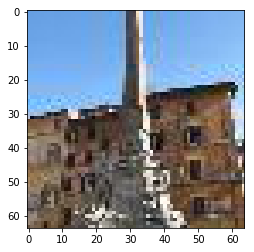

In [4]:
SAMPLE_INDEX = 0  # Change to see another image.

assert 0 <= SAMPLE_INDEX < len(images)

plt.imshow(images[SAMPLE_INDEX])

Parece que estamos listos para seguir adelante. ¡Sigamos!

## Proyectando Imágenes a un Espacio de N Dimensiones

Dado el conjunto de imágenes que recopilamos en el paso anterior, podemos proceder a organizarlas de manera que fotos similares estén cercanas entre sí en el espacio vectorial producido por la penúltima capa de una red pre-entrenada. En otras pralabras, podemos utilizar los parámetros de esta capa como _embeddings_ de imágenes.

Comencemos cargando un modelo pre-entrenado. Esta vez, optaremos por usar `InceptionV3`.

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Nuestra capa objetivo es `avg_pool`, la cual produce vectores de 2048 elementos. Este será el número de dimensiones de nuestros _embeddings_ de imágenes. 

In [6]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

Muy bien. Creemos una función que, dada una imagen, retorne su representación vectorial.

In [7]:
def get_vector(model, img):
    if not isinstance(img, list):
        images = [img]
    else:
        images = img
        
    target_size = (299, 299)  # Default for ImagenetV3
    images = [cv2.resize(i, target_size) for i in images]

    pre_processed_images = preprocess_input(np.asarray(images))
    
    return model.predict(pre_processed_images)

processed_batch = get_vector(model, images[:10])
print(f'Processed batch shape: {processed_batch.shape}')

Processed batch shape: (10, 2048)


Para no abusar de nuestra RAM, procesemos el conjunto de datos por lotes. Por supuesto, si tu RAM tiene suficiente capacidad, aumenta el `CHUNK_SIZE` o, incluso, procesa toda la data en una sola corrida. Para este notebook, usé una instancia de FloydHub con 61 GB de RAM.

In [8]:
CHUNK_SIZE = 512

processed_chunks = []
for chunk_index in range(0, len(images), CHUNK_SIZE):
    chunk = images[chunk_index:(chunk_index + CHUNK_SIZE)]
    processed_chunk = get_vector(model, chunk)
    
    processed_chunks.append(processed_chunk)
    
    print(f'Processed {chunk_index + CHUNK_SIZE} images of {len(images)}')
    
vectors = np.concatenate(processed_chunks)

Processed 512 images of 117822
Processed 1024 images of 117822
Processed 1536 images of 117822
Processed 2048 images of 117822
Processed 2560 images of 117822
Processed 3072 images of 117822
Processed 3584 images of 117822
Processed 4096 images of 117822
Processed 4608 images of 117822
Processed 5120 images of 117822
Processed 5632 images of 117822
Processed 6144 images of 117822
Processed 6656 images of 117822
Processed 7168 images of 117822
Processed 7680 images of 117822
Processed 8192 images of 117822
Processed 8704 images of 117822
Processed 9216 images of 117822
Processed 9728 images of 117822
Processed 10240 images of 117822
Processed 10752 images of 117822
Processed 11264 images of 117822
Processed 11776 images of 117822
Processed 12288 images of 117822
Processed 12800 images of 117822
Processed 13312 images of 117822
Processed 13824 images of 117822
Processed 14336 images of 117822
Processed 14848 images of 117822
Processed 15360 images of 117822
Processed 15872 images of 1178

## Hallando los Vecinos Más Cercanos en un Espacio Multidimensional

Ahora que todas las imágenes en el dataset han sido proyectadas a un espacio de 2048 dimensions, podemos construir un modelo `k-Nearest Neighbors` para obtener las imágenes más similares (es decir, vecinos) en este espacio.

In [9]:
NUMBER_OF_NEIGHBORS = 10
n_neighbors = NearestNeighbors(n_neighbors=NUMBER_OF_NEIGHBORS, algorithm='ball_tree')
neighbors = n_neighbors.fit(vectors)

Veamos cuáles son los vecinos de nuestra siempre confiable imagen de un Pug. Para tal propósito utilizaremos la siguiente función.

In [10]:
def get_and_plot_neighbors(model, neighbors, images, image_path):
    pug_image = mpimg.imread(image_path)
    pug_vector = get_vector(model, pug_image)

    distances, indices = neighbors.kneighbors(pug_vector)


    plt.figure(figsize=(20,10))
    columns = 5

    for i, (index, distance) in enumerate(zip(indices[0], distances[0])):
        plt.subplot(len(distances[0]) / columns + 1, columns, i + 1)
        plt.title(f'Distance: {distance}')
        plt.imshow(images[index])

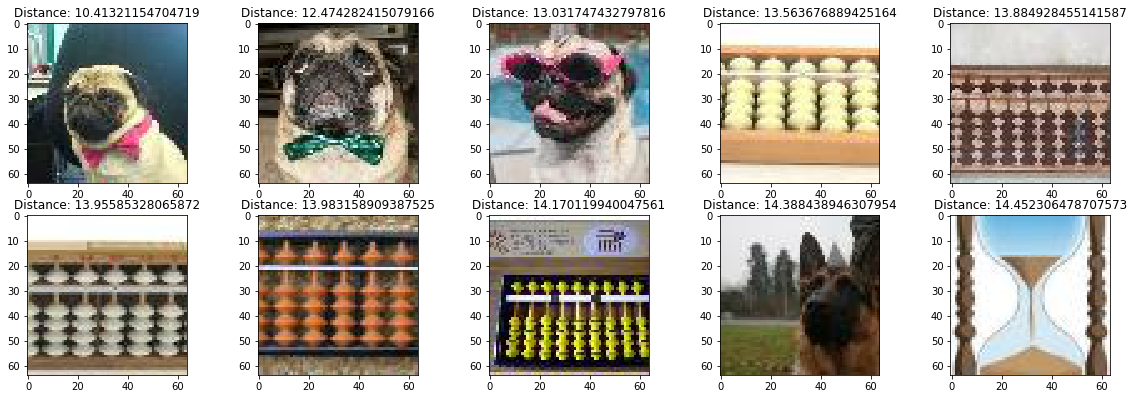

In [11]:
get_and_plot_neighbors(model, neighbors, images, 'data/pug.jpeg')

Impresionante. No solo los tres vecinos más cercanos son perros, ¡sino Pugs!. También vemos otras imágenes relacionadas con cosas que claramente no son Pugs, como un reloj de arena.

Intentemos ahora con una imagen de un carro:

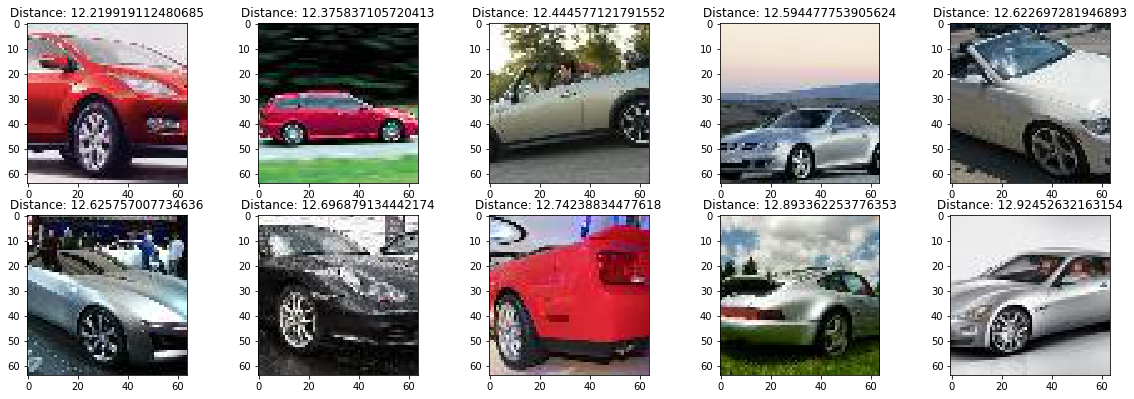

In [12]:
get_and_plot_neighbors(model, neighbors, images, 'data/tesla.jpg')

Tal parece que nuestro motor de búsqueda de imágenes domina el concepto de un **carro** a la perfección.

Intentemos ahora con una imagen de una guitarra:

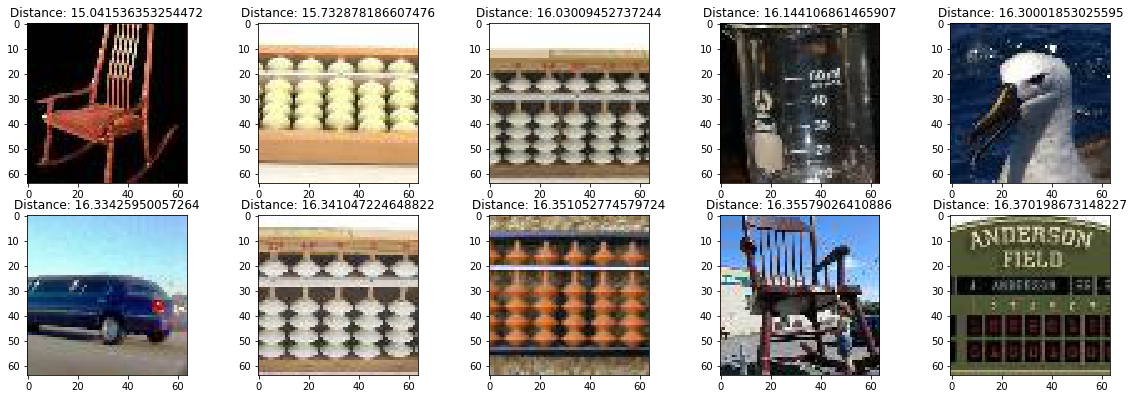

In [13]:
get_and_plot_neighbors(model, neighbors, images, 'data/guitar.jpg')

Esto es interesante. Ninguna de las imágenes de la vecindad contiene una guitarra. Parece, sin embargo, que el color es una característica que ha sido tomada en cuenta en el vector representativo de cada imagen, puesto que en 6 de estas fotos las tonalidades de color son parecidas a las de la guitarra que le pasamos a nuestra red neuronal. Esto puede ser una consecuencia de datos insuficientes en nuestro dataset, o simplemente que la categoría **guitarra** no está presente en el corpus de Tiny ImageNet.